# We are not providing you with any code for this assignment, so you must code everything yourself. However, we are providing you with an example notebook on how to run an MCMC.
# Furthermore, we provide a noise-free and noisy reference model from which you must derive parameters. Lastly, we give you three noisy covariance matrices.
# We recommend running the MCMC not in a Jupyter Notebook but instead using an external Python script.

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
from cosmopower_NN import cosmopower_NN
import tensorflow as tf
import gc
import emcee
import multiprocess as mp
import os 
from getdist import plots, MCSamples, parampriors
import getdist
from sklearn.decomposition import PCA
from scipy.stats import chi2

In [2]:
cov=np.load('data_4_assignment3/covariance.npy')
cov_inv = inv(cov)

minimum=np.load('data_4_assignment3/minimum.npy')
maximum=np.load('data_4_assignment3/maximum.npy')

reference_model = np.load('data_4_assignment3/reference_model.npy')
reference_model_noisy = np.load('data_4_assignment3/reference_model_noise.npy')

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final')

cov_num_1500 = np.load('data_4_assignment3/cov_num_1500.npy')
cov_num_3000 = np.load('data_4_assignment3/cov_num_3000.npy')
cov_num_10000 = np.load('data_4_assignment3/cov_num_10000.npy')

## You can use any sampler you like to use for the following tasks. Also, you can use your own emulator. You must use the noisy reference model for the first three tasks. Check for each task that the posteriors and the $\chi^2$ distributions are as expected.
## Your tasks for this week are the following:

### 1. Run an MCMC where you vary all four parameters you have trained on your emulator.
### 2. Use the provided numerical covariance matrices with [1.5k,3k,10k] data vectors as in assignment one. Run an MCMC for all of them with and without Hartlap correction, and compare with your results. Link your results to assignment one.
### 3. Next, we consider PCA data compression. Run an MCMC for several numbers of PCA elements. Link your results to assignment two.
####    3.a. Use the analytical covariance matrix.
####    3.b. Use the 1.5k covariance matrix. Do you observe the same trend as in 3.a?
### 4. Run task 3 with the noise-free reference model. What difference do you observe in the MCMC chain and the corresponding $\chi^2$ distributions?
#### 4.a Plot and compare the marginalised constraints on $\Omega_\mathrm{m}$ and $A_s$, as a function of the number of PCA elements. What do you observe?
#### 4.b To check if your answer in 4.a is robust, run multiple MCMC chains with the 1.5 covariance matrix and a fixed number of PCA elements. How big are the variations on the marginalised errors on $\Omega_\mathrm{m}$ and $A_s$? Is your answer in 4.a reliable? What can you improve to make 4.a reliable?

### 5. Bonus: Use an MCMC sampler not described in the attached notebook. Compare its performance (speed, accuracy) to the samplers we provided.
###

# Task 1

In [3]:
parameters = np.load('data_4_assignment2/parameters.npz')
reference_params = {}
for name in parameters.keys():
    reference_params[name]=list(np.array(parameters[name]))

models = np.load('data_4_assignment2/models.npy')  
ref_model = reference_model_noisy

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final')

train_sample = np.arange(0,7000)
train_features = np.load('data_4_assignment2/models.npy')[train_sample]
minimum=np.min(train_features,axis=0)
maximum=np.max(train_features-minimum,axis=0)

In [4]:
total_steps = 2000 # total  number of steps each walker is doing
burning_steps = 100 # how many buring steps you want to remove
nwalkers = 50 # Number of walkers that probe the parameter space

num_threads = 10 # number of cpu cores to use

#which parameters we want to vary
parameters = np.load('data_4_assignment2/parameters.npz')
param_names_varying = ['omega_m', 'omega_b', 'As', 'w'] # alternatively you can also just use parameters.files
ndim = len(param_names_varying)


## a function that distributed start postions inside the trained parameters
def start_position_lh_and_step_size(seed):
    random.seed(seed)
    mins = {'omega_m':0.33, 'omega_b':0.035, 'As':1.9e-9, 'w':-1.2}
    maxs = {'omega_m':0.36, 'omega_b':0.06, 'As':2.2e-9, 'w':-0.8}
    p0 = []
    for i in range(nwalkers):
        random_starts = []
        
        for name in param_names_varying:
            lower_edge = np.min(mins[name])
            upper_edge = np.max(maxs[name])
            if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01     
                
            random_starts.append(random.uniform(lower_edge,upper_edge))

        p0.append(random_starts)
        
    return np.array(p0)

## function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior

## Function that computes the likelihood
def calc_likelihood(para):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'],\
              'As':reference_params['As'],'omega_m':reference_params['omega_m']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    
    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - ref_model
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior



print(emcee.__version__)
p0 = start_position_lh_and_step_size(0)

3.1.4


In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('outputs_A3/MCMC_test_emcee',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('outputs_A3/logp_test_emcee',log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:52<00:00,  3.76it/s]


In [54]:
samples_emcee = np.load('outputs_A3/MCMC_test_emcee.npy')
log_prob_samples = np.load('outputs_A3/logp_test_emcee.npy')

Removed no burn in


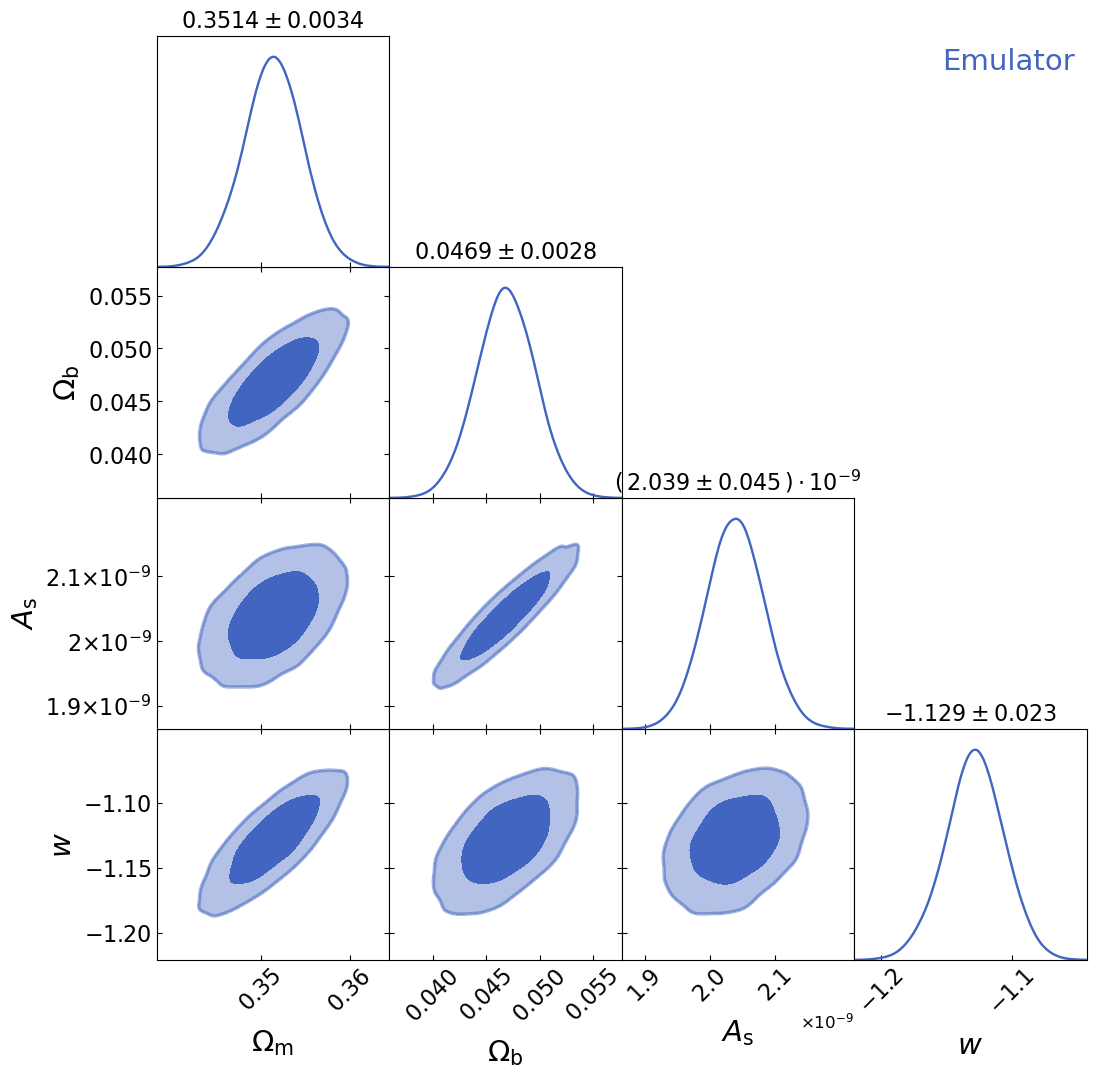

In [6]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['Emulator'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3.jpg',dpi=400, bbox_inches='tight')


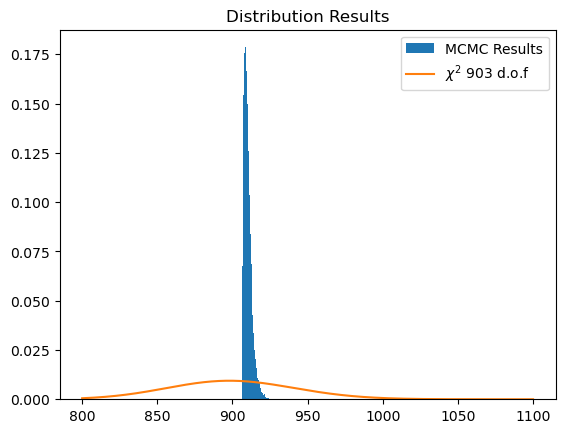

In [56]:
plt.hist(log_prob_samples*(-2), bins=40, density=True, label='MCMC Results')
df = 903
x = np.linspace(800,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results')
plt.legend()
plt.show()

# Task 1 Discussion

The corner plot provides the distribution results of the MCMC using the emulator. These results seem promising, with reasonable distributions.<br>
However, we see that this does not follow a theoretical $\chi^2$ distribution for 903 degrees of freedom. Although the mean is close to 903.

# Task 2

## 1.5k vector covariance

### No Hartlap factor

In [11]:
cov_inv = inv(cov_num_1500)
p1 = start_position_lh_and_step_size(1)

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p1, total_steps, progress=True)
samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('outputs_A3/MCMC_task2_1p5k_samples',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('outputs_A3/MCMC_task2_1p5k_log',log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [11:48<00:00,  2.82it/s]


In [57]:
samples_emcee = np.load('outputs_A3/MCMC_task2_1p5k_samples.npy')
log_prob_samples = np.load('outputs_A3/MCMC_task2_1p5k_log.npy')

In [29]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['1.5k No Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_1p5k.jpg',dpi=400, bbox_inches='tight')

Removed no burn in


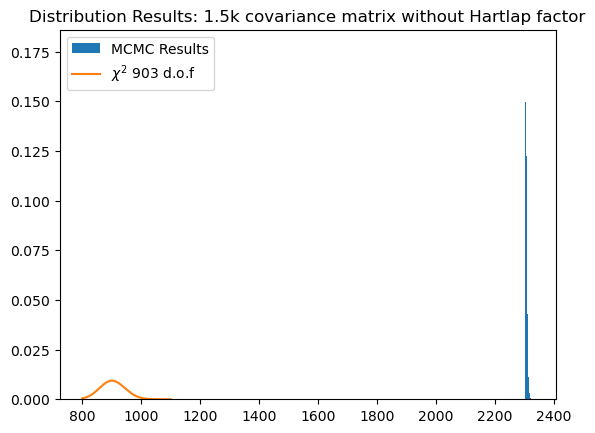

In [58]:
plt.hist(log_prob_samples*(-2), bins=40, density=True, label='MCMC Results')
df = 903
x = np.linspace(800,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 1.5k covariance matrix without Hartlap factor')
plt.legend()
plt.show()

### With Hartlap factor

In [13]:
n_d = 900 # diemension of the model
n_r = 1500 # number of realisations used 
h = (n_r-1)/(n_r-n_d-2)

cov_inv = inv(cov_num_1500)/h
p1 = start_position_lh_and_step_size(1)

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p1, total_steps, progress=True)
samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('outputs_A3/MCMC_task2_1p5k_2_samples',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('outputs_A3/MCMC_task2_1p5k_2_log',log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [16:03<00:00,  2.08it/s]


In [59]:
samples_emcee = np.load('outputs_A3/MCMC_task2_1p5k_2_samples.npy')
log_prob_samples = np.load('outputs_A3/MCMC_task2_1p5k_2_log.npy')

Removed no burn in


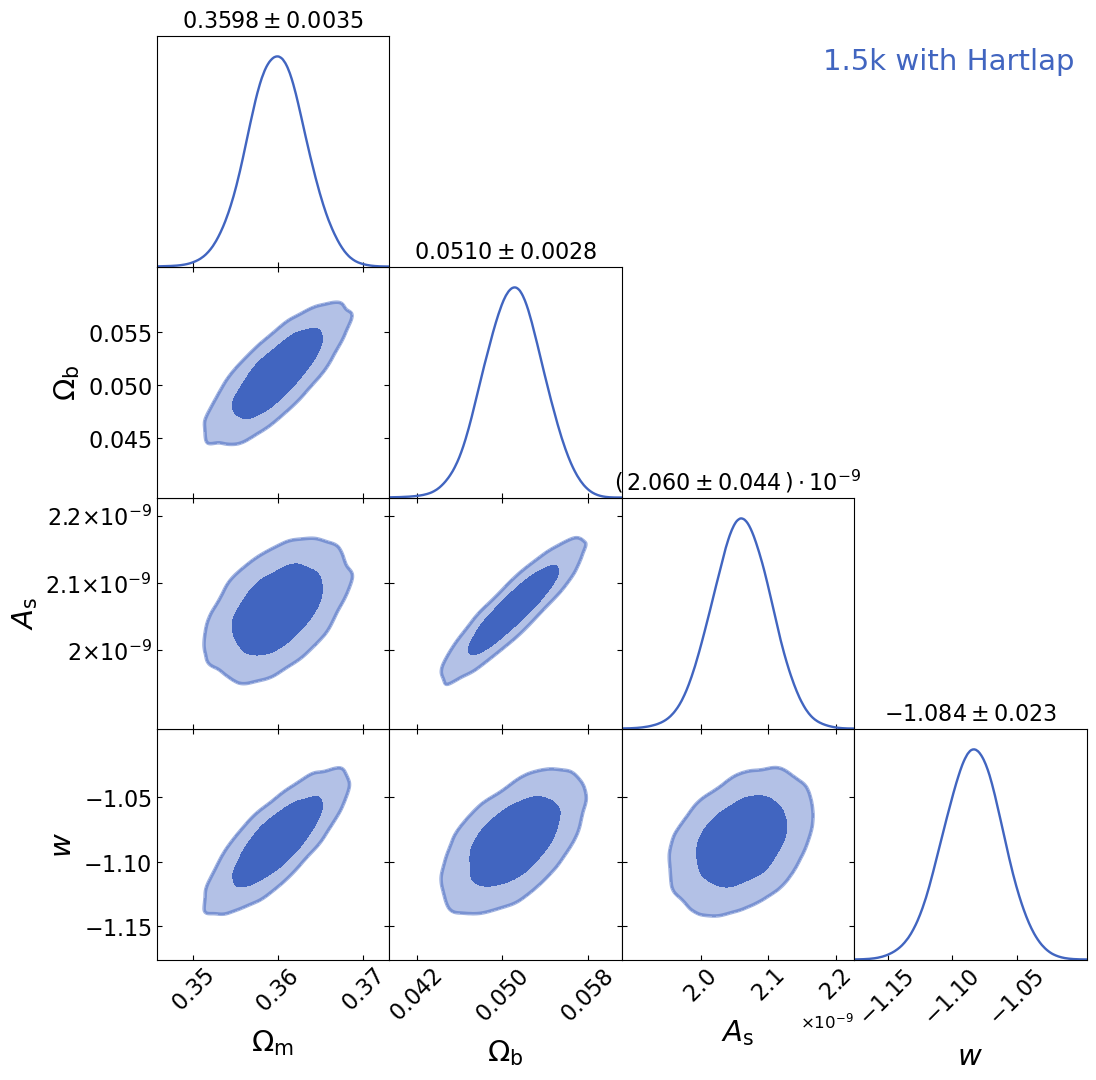

In [13]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['1.5k with Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_1p5k_2.jpg',dpi=400, bbox_inches='tight')

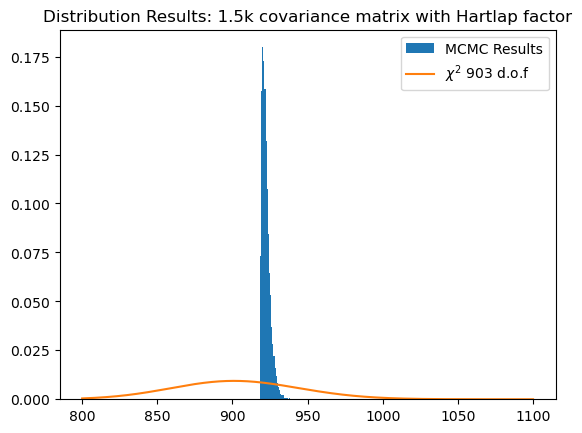

In [60]:
plt.hist(log_prob_samples*(-2), bins=40, density=True, label='MCMC Results')
df = 903
x = np.linspace(800,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 1.5k covariance matrix with Hartlap factor')
plt.legend()
plt.show()

## 3k vector covariance

### No Hartlap factor

In [15]:
cov_inv = inv(cov_num_3000)
p2 = start_position_lh_and_step_size(2)

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p2, total_steps, progress=True)
samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('outputs_A3/MCMC_task2_3k_samples',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('outputs_A3/MCMC_task2_3k_log',log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:58<00:00,  3.34it/s]


In [61]:
samples_emcee = np.load('outputs_A3/MCMC_task2_3k_samples.npy')
log_prob_samples = np.load('outputs_A3/MCMC_task2_3k_log.npy')

Removed no burn in


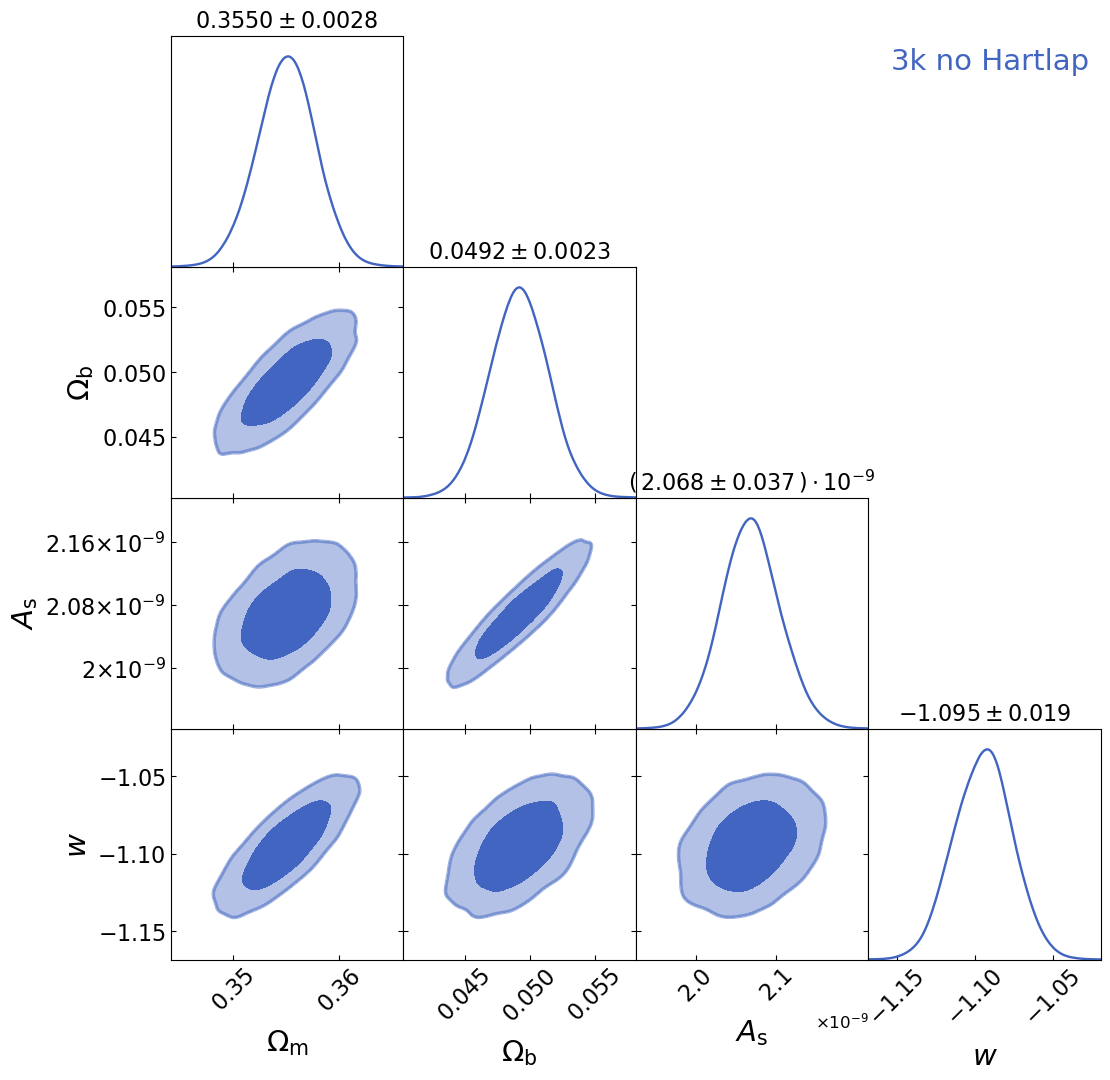

In [15]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['3k no Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_3k.jpg',dpi=400, bbox_inches='tight')

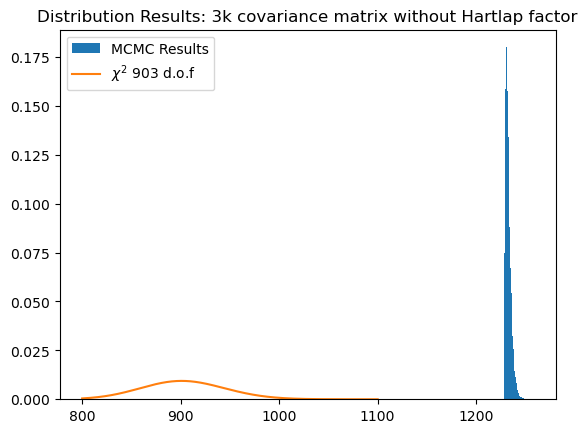

In [62]:
plt.hist(log_prob_samples*(-2), bins=40, density=True, label='MCMC Results')
df = 903
x = np.linspace(800,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 3k covariance matrix without Hartlap factor')
plt.legend()
plt.show()

### With Harlap factor

In [19]:
n_d = 900 # diemension of the model
n_r = 3000 # number of realisations used 
h = (n_r-1)/(n_r-n_d-2)

cov_inv = inv(cov_num_3000)/h
p2 = start_position_lh_and_step_size(2)

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p2, total_steps, progress=True)
samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('outputs_A3/MCMC_task2_3k_2_samples',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('outputs_A3/MCMC_task2_3k_2_log',log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:14<00:00,  4.05it/s]


In [63]:
samples_emcee = np.load('outputs_A3/MCMC_task2_3k_2_samples.npy')
log_prob_samples = np.load('outputs_A3/MCMC_task2_3k_2_log.npy')

In [17]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['3k with Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_3k_2.jpg',dpi=400, bbox_inches='tight')

Removed no burn in


In [64]:
plt.hist(log_prob_samples*(-2), bins=40, density=True, label='MCMC Results')
df = 903
x = np.linspace(800,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 3k covariance matrix with Hartlap factor')
plt.legend()
plt.show()

## 10k vector covariance

### No Hartlap factor

In [19]:
cov_inv = inv(cov_num_10000)
p3 = start_position_lh_and_step_size(3)

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p3, total_steps, progress=True)
samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('outputs_A3/MCMC_task2_10k_samples',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('outputs_A3/MCMC_task2_10k_log',log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:25<00:00,  4.49it/s]


In [65]:
samples_emcee = np.load('outputs_A3/MCMC_task2_10k_samples.npy')
log_prob_samples = np.load('outputs_A3/MCMC_task2_10k_log.npy')

In [19]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['10k no Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_10k.jpg',dpi=400, bbox_inches='tight')

Removed no burn in


In [66]:
plt.hist(log_prob_samples*(-2), bins=40, density=True, label='MCMC Results')
df = 903
x = np.linspace(800,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 10k covariance matrix without Hartlap factor')
plt.legend()
plt.show()

## With Hartlap factor

In [50]:
n_d = 900 # diemension of the model
n_r = 10000 # number of realisations used 
h = (n_r-1)/(n_r-n_d-2)

cov_inv = inv(cov_num_10000)/h
p3 = start_position_lh_and_step_size(3)

sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p3, total_steps, progress=True)
samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('outputs_A3/MCMC_task2_10k_2_samples',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('outputs_A3/MCMC_task2_10k_2_log',log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:09<00:00,  3.28it/s]


In [67]:
samples_emcee = np.load('outputs_A3/MCMC_task2_10k_2_samples.npy')
log_prob_samples = np.load('outputs_A3/MCMC_task2_10k_2_log.npy')

In [22]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['10k with Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_10k_2.jpg',dpi=400, bbox_inches='tight')

Removed no burn in


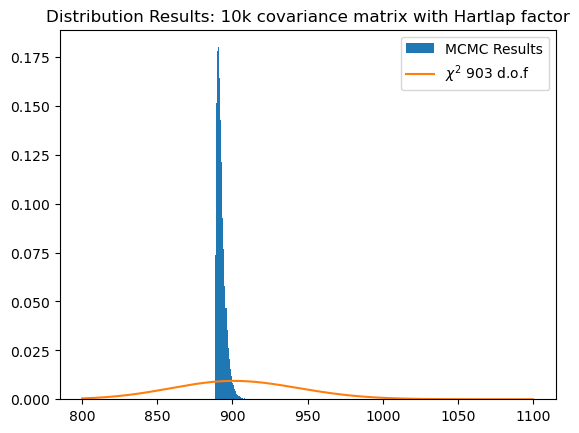

In [68]:
plt.hist(log_prob_samples*(-2), bins=40, density=True, label='MCMC Results')
df = 903
x = np.linspace(800,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 10k covariance matrix with Hartlap factor')
plt.legend()
plt.show()

## Comparing Results

In [69]:
samples_1 = np.load('outputs_A3/MCMC_task2_1p5k_samples.npy')
logsamples_1 = np.load('outputs_A3/MCMC_task2_1p5k_log.npy')
samples_2 = np.load('outputs_A3/MCMC_task2_3k_samples.npy')
logsamples_2 = np.load('outputs_A3/MCMC_task2_3k_log.npy')
samples_3 = np.load('outputs_A3/MCMC_task2_10k_samples.npy')
logsamples_3 = np.load('outputs_A3/MCMC_task2_10k_log.npy')

samples_1_h = np.load('outputs_A3/MCMC_task2_1p5k_2_samples.npy')
logsamples_1_h = np.load('outputs_A3/MCMC_task2_1p5k_2_log.npy')
samples_2_h = np.load('outputs_A3/MCMC_task2_3k_2_samples.npy')
logsamples_2_h = np.load('outputs_A3/MCMC_task2_3k_2_log.npy')
samples_3_h = np.load('outputs_A3/MCMC_task2_10k_2_samples.npy')
logsamples_3_h = np.load('outputs_A3/MCMC_task2_10k_2_log.npy')

### 1.5k Covariance: With vs Without Hartlap

Removed no burn in
Removed no burn in


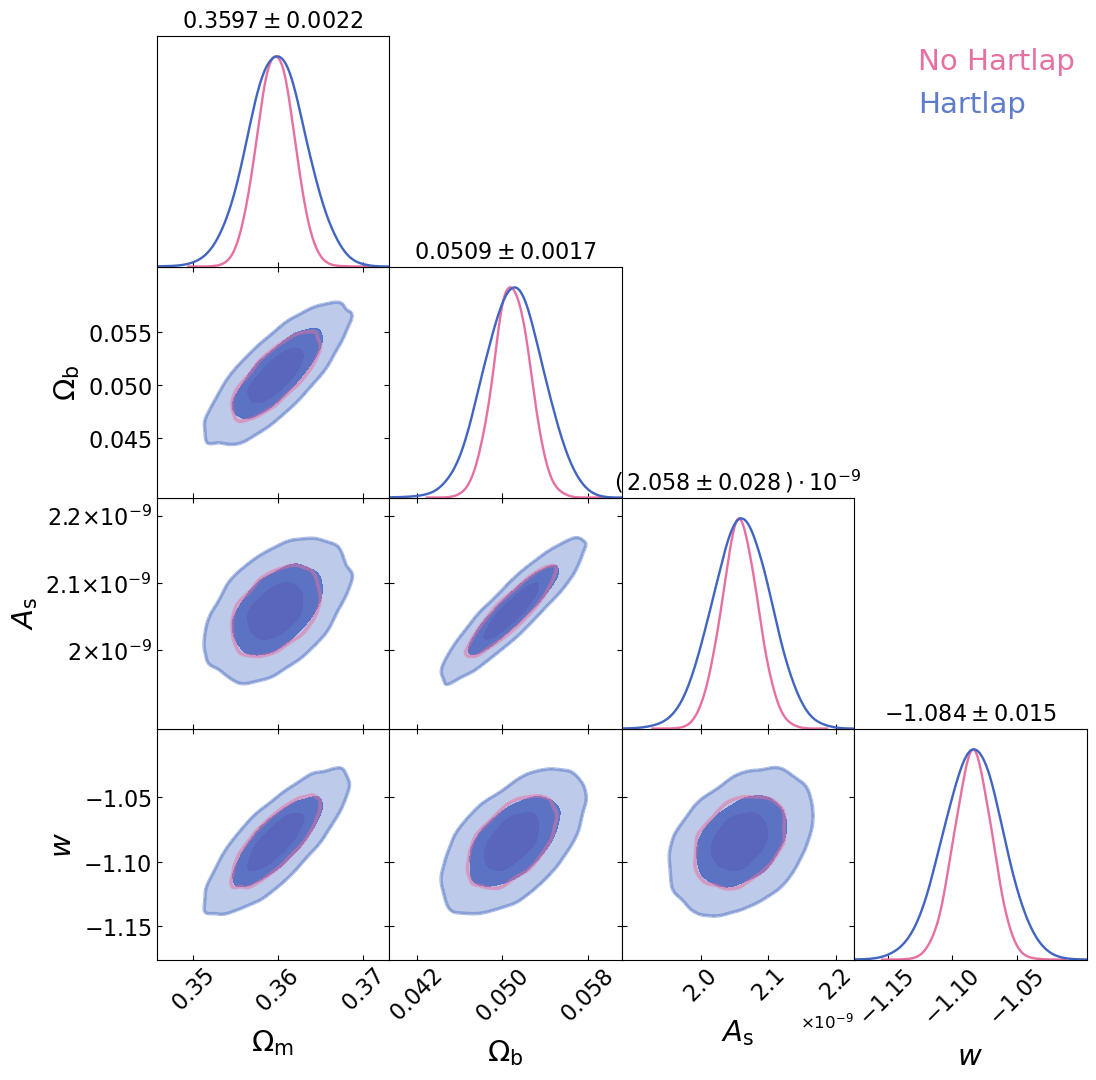

In [24]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_1, samples_1_h]
samples_getdist = []
for sample in samples_array:
    samples_getdist.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['No Hartlap', 'Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_compare_1p5k.jpg',dpi=400, bbox_inches='tight')

### 3k Covariance: With vs Without Hartlap

Removed no burn in
Removed no burn in


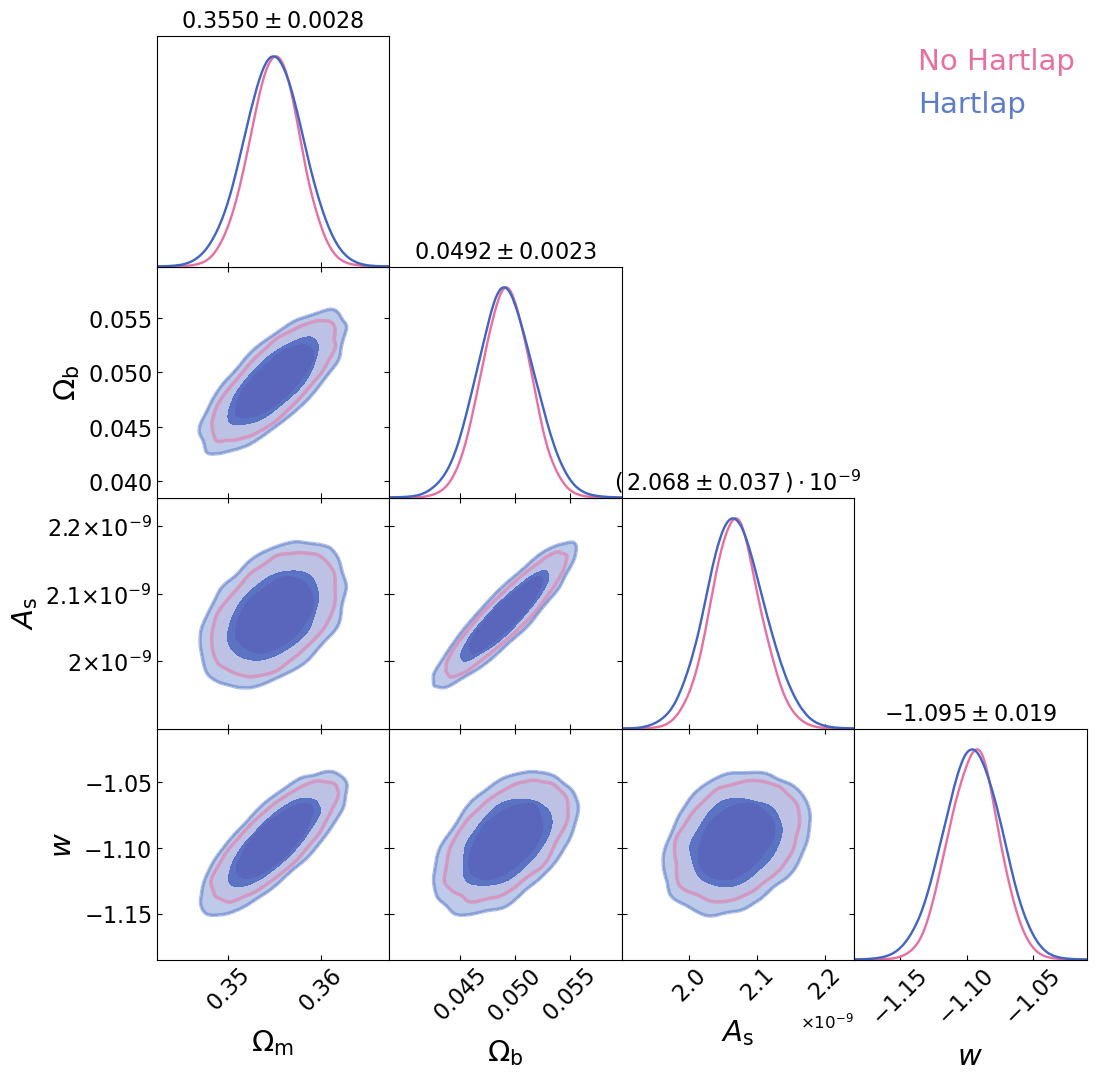

In [35]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_2, samples_2_h]
samples_getdist = []
for sample in samples_array:
    samples_getdist.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['No Hartlap', 'Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_compare_3k.jpg',dpi=400, bbox_inches='tight')

### 10k Covariance: With vs Without Hartlap

Removed no burn in
Removed no burn in


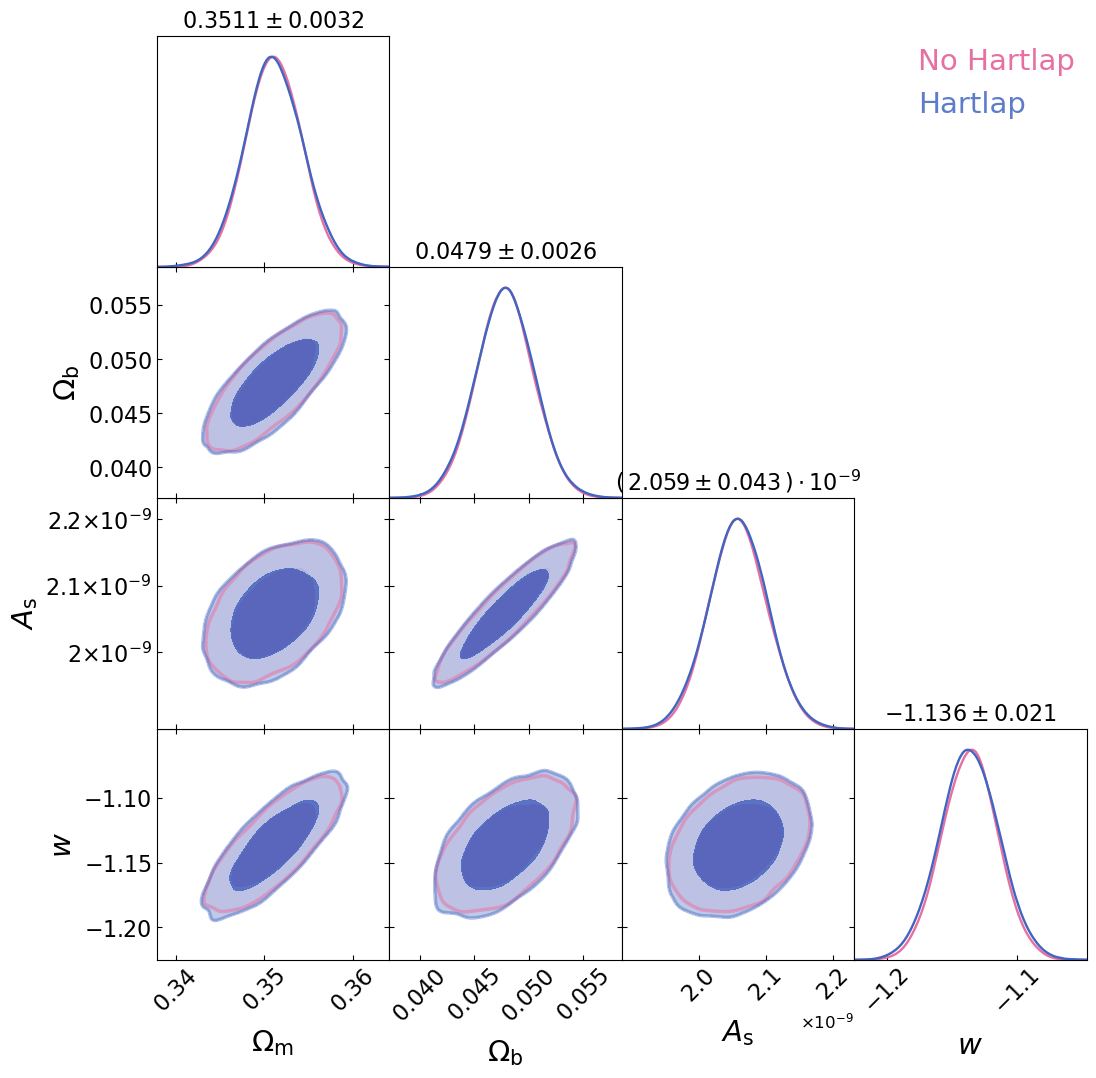

In [36]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_3, samples_3_h]
samples_getdist = []
for sample in samples_array:
    samples_getdist.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['No Hartlap', 'Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_compare_10k.jpg',dpi=400, bbox_inches='tight')

### All covariances, comparing without vs with Hartlap

Removed no burn in
Removed no burn in
Removed no burn in


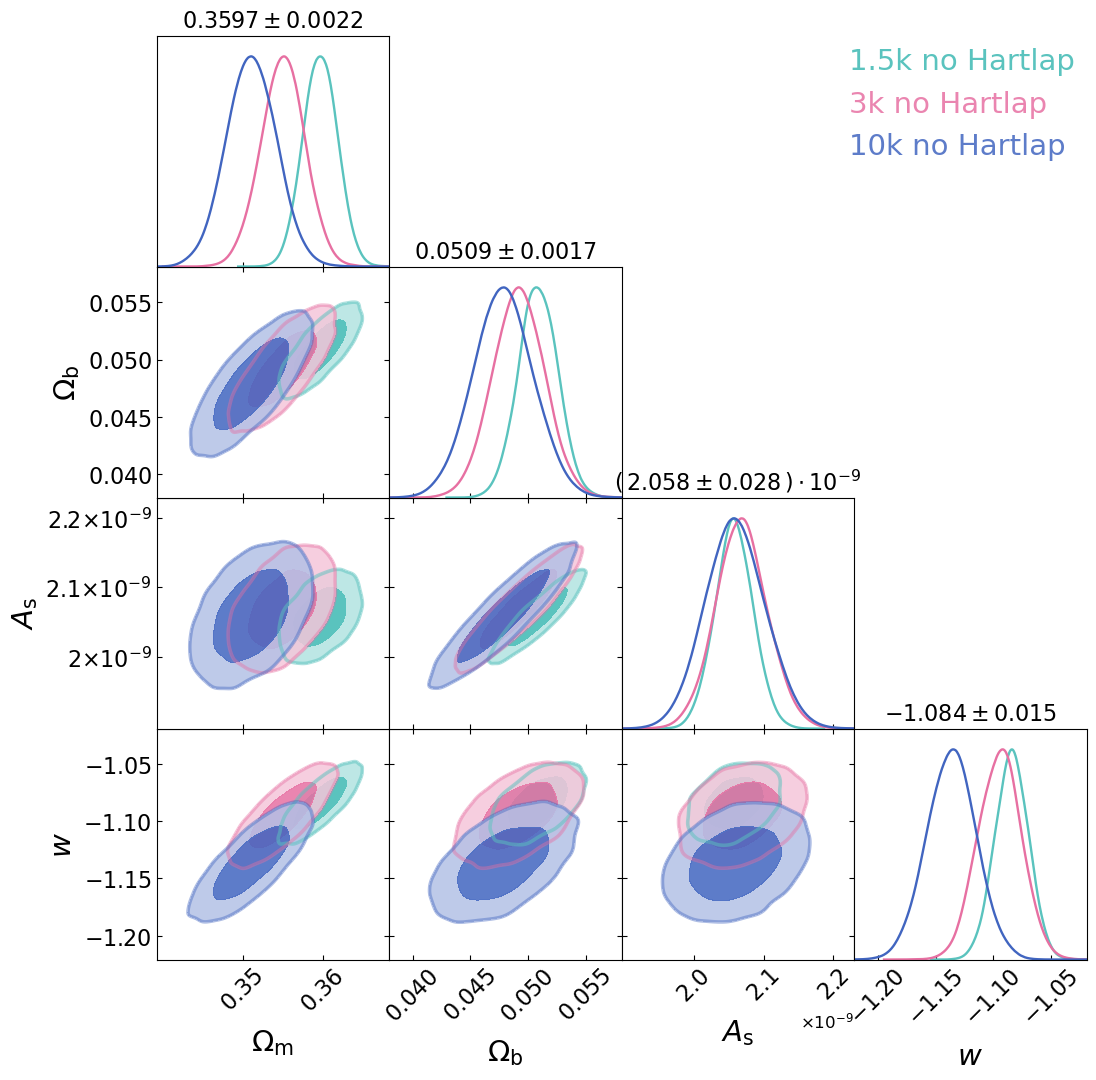

In [6]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_1, samples_2, samples_3]
samples_getdist = []
for sample in samples_array:
    samples_getdist.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['1.5k no Hartlap', '3k no Hartlap', '10k no Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_compare_all.jpg',dpi=400, bbox_inches='tight')

Removed no burn in
Removed no burn in
Removed no burn in


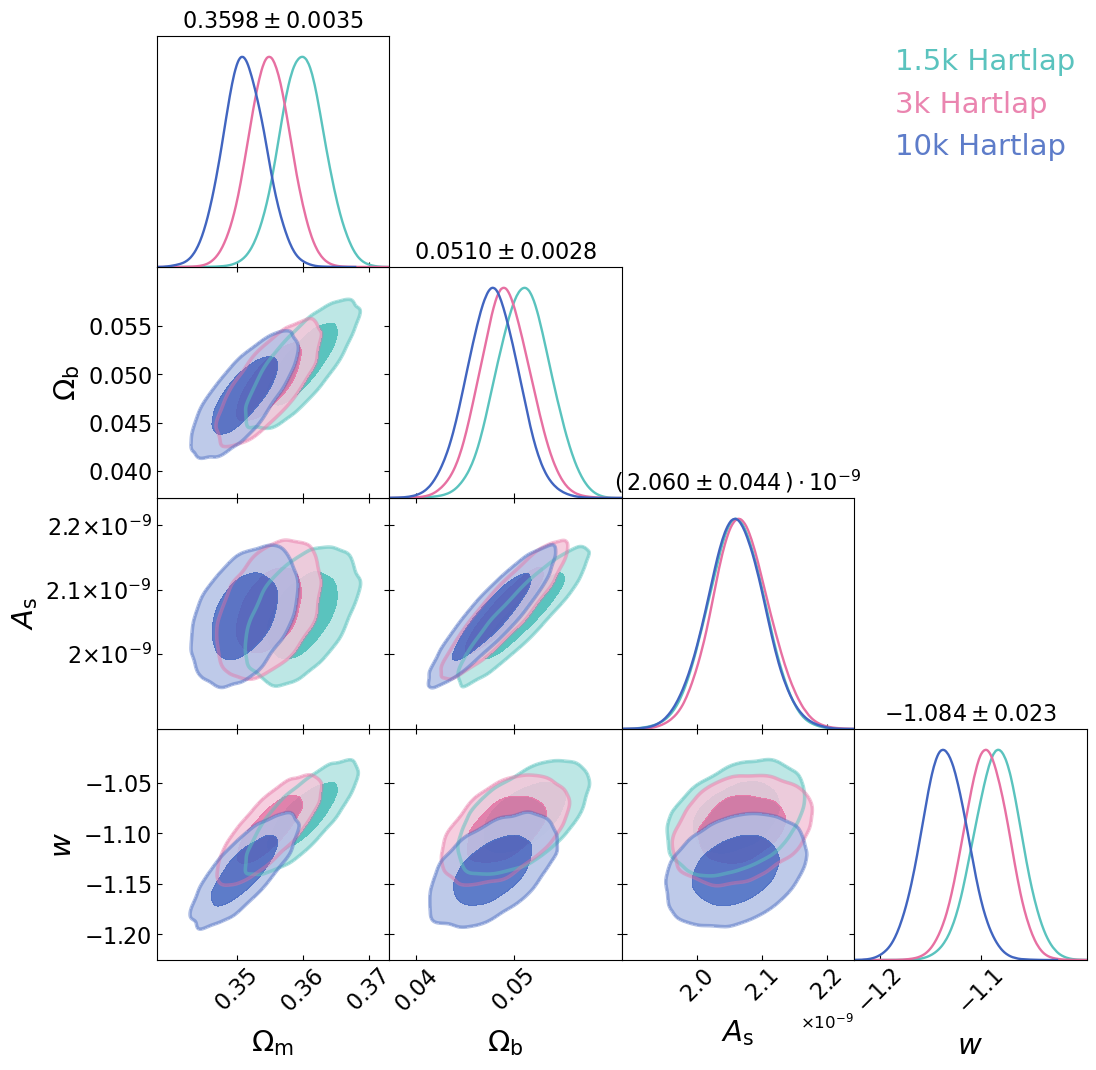

In [7]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_1_h, samples_2_h, samples_3_h]
samples_getdist = []
for sample in samples_array:
    samples_getdist.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['1.5k Hartlap', '3k Hartlap', '10k Hartlap'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task2_compare_all_hartlap.jpg',dpi=400, bbox_inches='tight')

# Task 2 Discussion

Comparing the results of the distributions between the 1.5k, 3k, and 10k covariance matrices. We see that the results between the different covariances are slightly off, with some overlap. This is expected, since the covariance matrix with more realizations should be more accurate. We do notice, however, that the use of the Hartlap factor significantly helps with getting better results. This is shown by the resulting $\chi^2$ distributions between without and with the Hartlap factor, as well as noticing that the overlap of the distributions in the corner plots increases.<br>
<br>
In assignment 1, we discovered that the use of the Hartlap factor debiased the numerical covariance matrices and obtained better results, most effective with a higher amount of realizations used in creating said covariance matrix. Despite the fact that the resulting $\chi^2$ distributions in this task are not close to the theoretical results, the trend we have observed with the results from this task certainly line up with the conclusions in assignment 1.

# Task 3

## Part a)

In [49]:
## a function that distributed start postions inside the trained parameters
def start_position_lh_and_step_size_pca(seed):
    random.seed(seed)
    mins = {'omega_m':0.33, 'omega_b':0.035, 'As':1.9e-9, 'w':-1.2}
    maxs = {'omega_m':0.36, 'omega_b':0.06, 'As':2.2e-9, 'w':-0.8}
    p0 = []
    for i in range(nwalkers):
        random_starts = []
        
        for name in param_names_varying:
            lower_edge = np.min(mins[name])
            upper_edge = np.max(maxs[name])
            if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01     
                
            random_starts.append(random.uniform(lower_edge,upper_edge))

        p0.append(random_starts)
        
    return np.array(p0)

## function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior_pca(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior

## Function that computes the likelihood
def calc_likelihood_pca(para):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w'],\
              'As':reference_params['As'],'omega_m':reference_params['omega_m']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    
    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    pred_vector = pca.transform([pred_vector])[0]
    ref_model = pca.transform([reference_model_noisy])[0]
    
    delta = pred_vector - ref_model
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior_pca(para_dict=params)

    return likelihood+lnprior

In [81]:
N_pca_array = [150, 300, 600, 900]
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(reference_model_noisy, axis=0)
for N_pca in N_pca_array:
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean)
    rotation_matrix = pca.components_.T
    cov_pca = np.matmul(np.matmul(rotation_matrix.T,cov),rotation_matrix)
    cov_inv = inv(cov_pca)
    
    p4 = start_position_lh_and_step_size_pca(4)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p4, total_steps, progress=True)

    samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
    np.save('outputs_A3/MCMC_task3a_{}_samples'.format(N_pca),samples_emcee)
    log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
    np.save('outputs_A3/logp_task3a_{}_log'.format(N_pca),log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:28<00:00,  3.93it/s]


In [70]:
samples_pca_1 = np.load('outputs_A3/MCMC_task3a_150_samples.npy')
samples_pca_2 = np.load('outputs_A3/MCMC_task3a_300_samples.npy')
samples_pca_3 = np.load('outputs_A3/MCMC_task3a_600_samples.npy')
samples_pca_4 = np.load('outputs_A3/MCMC_task3a_900_samples.npy')

log_samples_pca_1 = np.load('outputs_A3/logp_task3a_150_log.npy')
log_samples_pca_2 = np.load('outputs_A3/logp_task3a_300_log.npy')
log_samples_pca_3 = np.load('outputs_A3/logp_task3a_600_log.npy')
log_samples_pca_4 = np.load('outputs_A3/logp_task3a_900_log.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


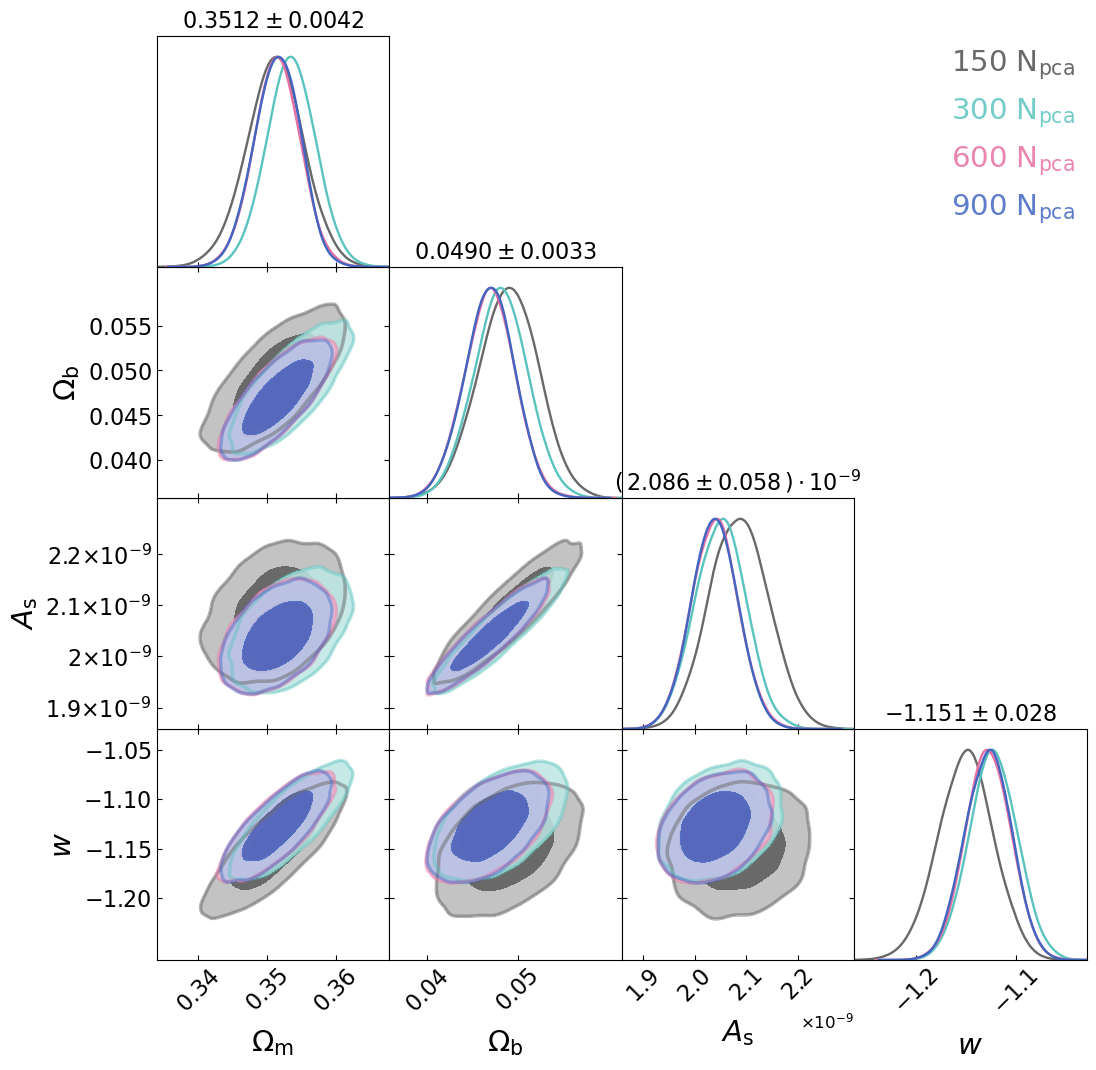

In [54]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_pca_1, samples_pca_2, samples_pca_3, samples_pca_4]
samples_getdist = []
for sample in samples_array:
    samples_getdist.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['150 N$_\\text{pca}$', '300 N$_\\text{pca}$', '600 N$_\\text{pca}$', '900 N$_\\text{pca}$'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task3a_compare.jpg',dpi=400, bbox_inches='tight')

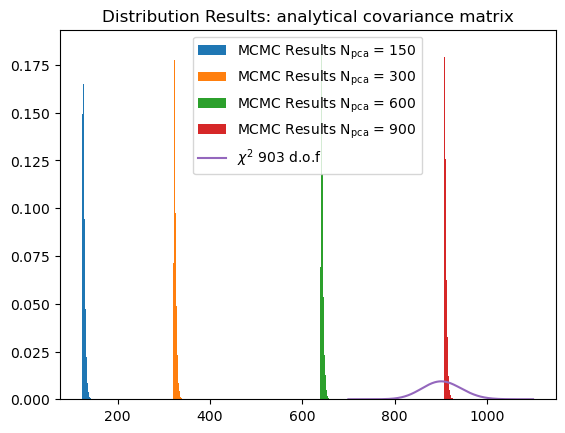

In [71]:
plt.hist(log_samples_pca_1*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 150')
plt.hist(log_samples_pca_2*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 300')
plt.hist(log_samples_pca_3*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 600')
plt.hist(log_samples_pca_4*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 900')
df = 903
x = np.linspace(700,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: analytical covariance matrix')
plt.legend()
plt.show()

## Part b)

In [9]:
N_pca_array = [150, 300, 600, 900]
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(reference_model_noisy, axis=0)
for N_pca in N_pca_array:
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean)
    rotation_matrix = pca.components_.T
    n_r, n_d = 1500, N_pca
    h = (n_r-1)/(n_r-n_d-2)
    cov_pca = np.matmul(np.matmul(rotation_matrix.T,cov_num_1500),rotation_matrix)
    cov_inv = inv(cov_pca)/h
    
    p4 = start_position_lh_and_step_size_pca(4)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p4, total_steps, progress=True)

    samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
    np.save('outputs_A3/MCMC_task3b_{}_samples'.format(N_pca),samples_emcee)
    log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
    np.save('outputs_A3/logp_task3b_{}_log'.format(N_pca),log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:34<00:00,  2.46it/s]


In [72]:
samples_pca_1 = np.load('outputs_A3/MCMC_task3b_150_samples.npy')
samples_pca_2 = np.load('outputs_A3/MCMC_task3b_300_samples.npy')
samples_pca_3 = np.load('outputs_A3/MCMC_task3b_600_samples.npy')
samples_pca_4 = np.load('outputs_A3/MCMC_task3b_900_samples.npy')

log_samples_pca_1 = np.load('outputs_A3/logp_task3b_150_log.npy')
log_samples_pca_2 = np.load('outputs_A3/logp_task3b_300_log.npy')
log_samples_pca_3 = np.load('outputs_A3/logp_task3b_600_log.npy')
log_samples_pca_4 = np.load('outputs_A3/logp_task3b_900_log.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


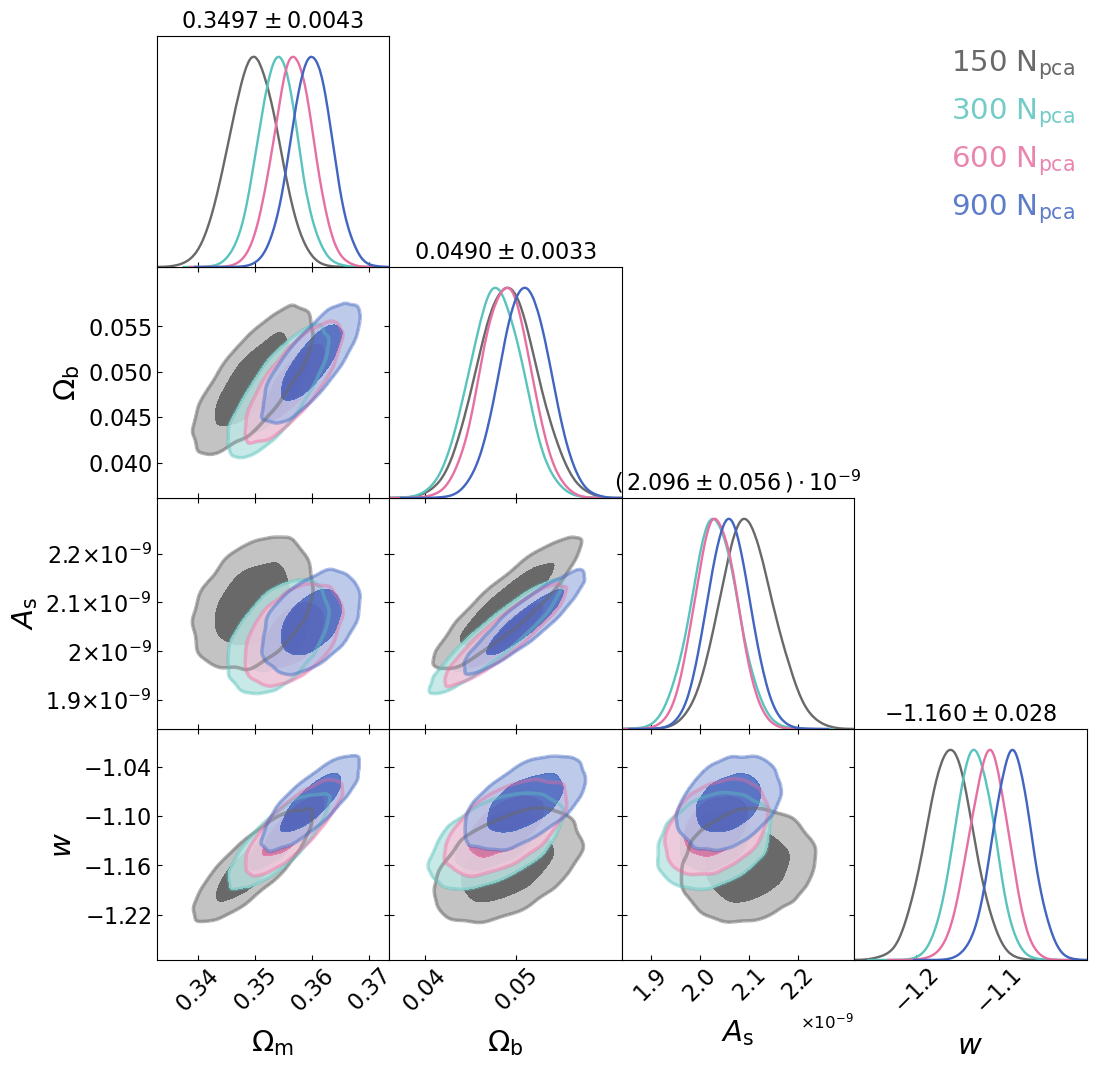

In [11]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_pca_1, samples_pca_2, samples_pca_3, samples_pca_4]
samples_getdist = []
for sample in samples_array:
    samples_getdist.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['150 N$_\\text{pca}$', '300 N$_\\text{pca}$', '600 N$_\\text{pca}$', '900 N$_\\text{pca}$'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task3b_compare.jpg',dpi=400, bbox_inches='tight')

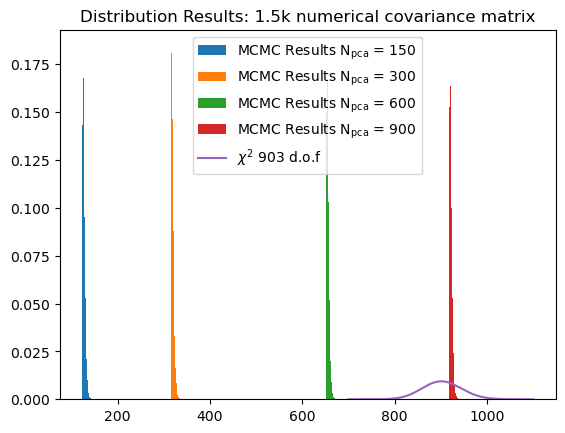

In [73]:
plt.hist(log_samples_pca_1*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 150')
plt.hist(log_samples_pca_2*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 300')
plt.hist(log_samples_pca_3*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 600')
plt.hist(log_samples_pca_4*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 900')
df = 903
x = np.linspace(700,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 1.5k numerical covariance matrix')
plt.legend()
plt.show()

# Task 3 Discussion

## Part a)
In assigment 2, we found that the constraining power of the results strongly depends on the number of PCA elements used. Particularly, we found that we achieve 10% and 1% constraining power at ~125 and ~500 PCA elements respectively. Here, we see that, although the resulting distributions in the corner plots seem to overlap, the constraints more closely line up to the analytical matrix with the 600 and 900 PCA elements. This is clearer when analyzing the $\chi^2$ distributions. By using N$_\text{pca}$ elements, the means of the $\chi^2$ distributions are close to that value. As a result, the trends observed in both assignment 2 and this task match.

## Part b)
In this case, we observe roughly the same trend as in part a. However, here the discrepancies between the 150 and 300 PCA element results and the 600 & 900 PCA element results are much larger, characterized by less overlap in the corner plots and larger gaps in the resulting $\chi^2$ distributions. We can say that the 1% constraining power trend observed is still reasonable, but the 10% constraining power at ~125 PCA elements is no longer reasonable.

# Task 4

In [25]:
N_pca_array = [150, 300, 600, 900]
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(reference_model, axis=0)

In [12]:
for N_pca in N_pca_array:
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean)
    rotation_matrix = pca.components_.T
    # Run using analytical covariance matrix
    cov_pca = np.matmul(np.matmul(rotation_matrix.T,cov),rotation_matrix)
    cov_inv = inv(cov_pca)
    
    p5 = start_position_lh_and_step_size_pca(5)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p5, total_steps, progress=True)

    samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
    np.save('outputs_A3/MCMC_task4_{}_analytic_samples'.format(N_pca),samples_emcee)
    log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
    np.save('outputs_A3/logp_task4_{}_analytic_log'.format(N_pca),log_prob_samples)
    
    # Run using numerical 1.5k covariance matrix
    n_r, n_d = 1500, N_pca
    h = (n_r-1)/(n_r-n_d-2)
    cov_pca = np.matmul(np.matmul(rotation_matrix.T,cov_num_1500),rotation_matrix)
    cov_inv = inv(cov_pca)/h
    
    p5 = start_position_lh_and_step_size_pca(5)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p5, total_steps, progress=True)

    samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
    np.save('outputs_A3/MCMC_task4_{}_1p5k_samples'.format(N_pca),samples_emcee)
    log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
    np.save('outputs_A3/logp_task4_{}_1p5k_log'.format(N_pca),log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:55<00:00,  3.36it/s]


In [74]:
samples_pca_1_analytic = np.load('outputs_A3/MCMC_task4_150_analytic_samples.npy')
samples_pca_2_analytic = np.load('outputs_A3/MCMC_task4_300_analytic_samples.npy')
samples_pca_3_analytic = np.load('outputs_A3/MCMC_task4_600_analytic_samples.npy')
samples_pca_4_analytic = np.load('outputs_A3/MCMC_task4_900_analytic_samples.npy')

log_samples_1_analytic = np.load('outputs_A3/logp_task4_150_analytic_log.npy')
log_samples_2_analytic = np.load('outputs_A3/logp_task4_300_analytic_log.npy')
log_samples_3_analytic = np.load('outputs_A3/logp_task4_600_analytic_log.npy')
log_samples_4_analytic = np.load('outputs_A3/logp_task4_900_analytic_log.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


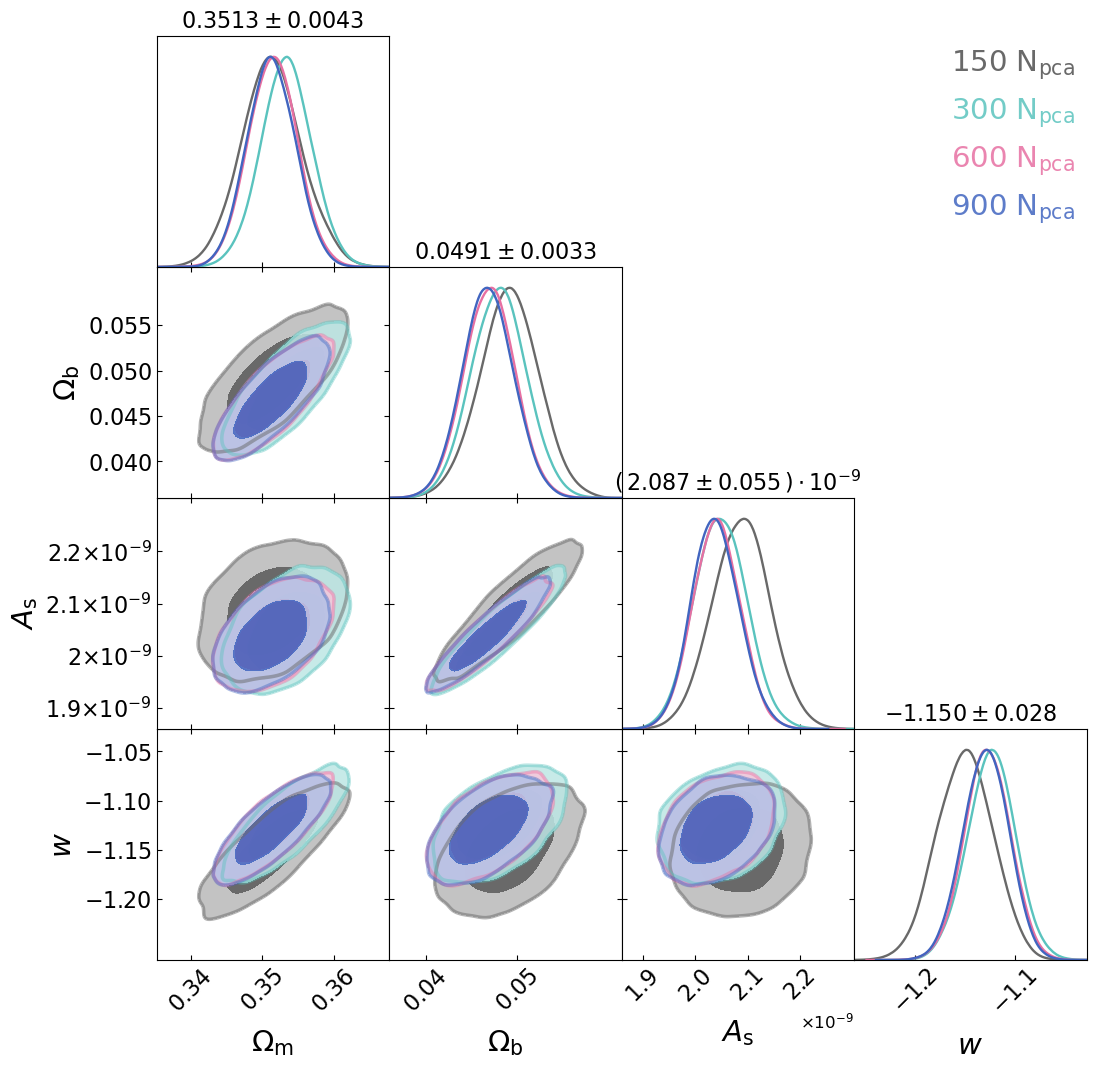

In [27]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_pca_1_analytic, samples_pca_2_analytic, samples_pca_3_analytic, samples_pca_4_analytic]
samples_getdist_analytic = []
for sample in samples_array:
    samples_getdist_analytic.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist_analytic,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['150 N$_\\text{pca}$', '300 N$_\\text{pca}$', '600 N$_\\text{pca}$', '900 N$_\\text{pca}$'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)
plt.savefig('plots/MCMC_A3_task4_analytic_compare.jpg',dpi=400, bbox_inches='tight')

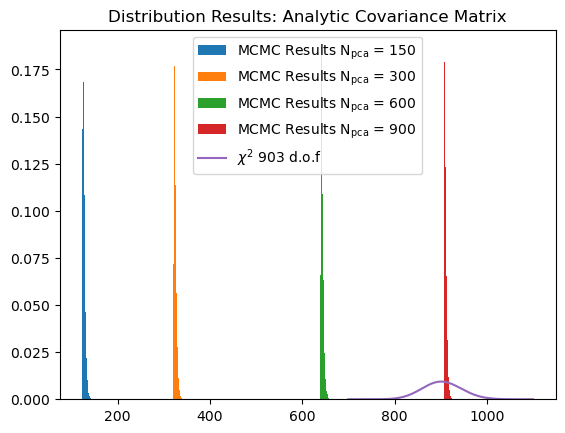

In [75]:
plt.hist(log_samples_1_analytic*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 150')
plt.hist(log_samples_2_analytic*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 300')
plt.hist(log_samples_3_analytic*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 600')
plt.hist(log_samples_4_analytic*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 900')
df = 903
x = np.linspace(700,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: Analytic Covariance Matrix')
plt.legend()
plt.show()

In [76]:
samples_pca_1_1500 = np.load('outputs_A3/MCMC_task4_150_1p5k_samples.npy')
samples_pca_2_1500 = np.load('outputs_A3/MCMC_task4_300_1p5k_samples.npy')
samples_pca_3_1500 = np.load('outputs_A3/MCMC_task4_600_1p5k_samples.npy')
samples_pca_4_1500 = np.load('outputs_A3/MCMC_task4_900_1p5k_samples.npy')

log_samples_1_1500 = np.load('outputs_A3/logp_task4_150_1p5k_log.npy')
log_samples_2_1500 = np.load('outputs_A3/logp_task4_300_1p5k_log.npy')
log_samples_3_1500 = np.load('outputs_A3/logp_task4_600_1p5k_log.npy')
log_samples_4_1500 = np.load('outputs_A3/logp_task4_900_1p5k_log.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


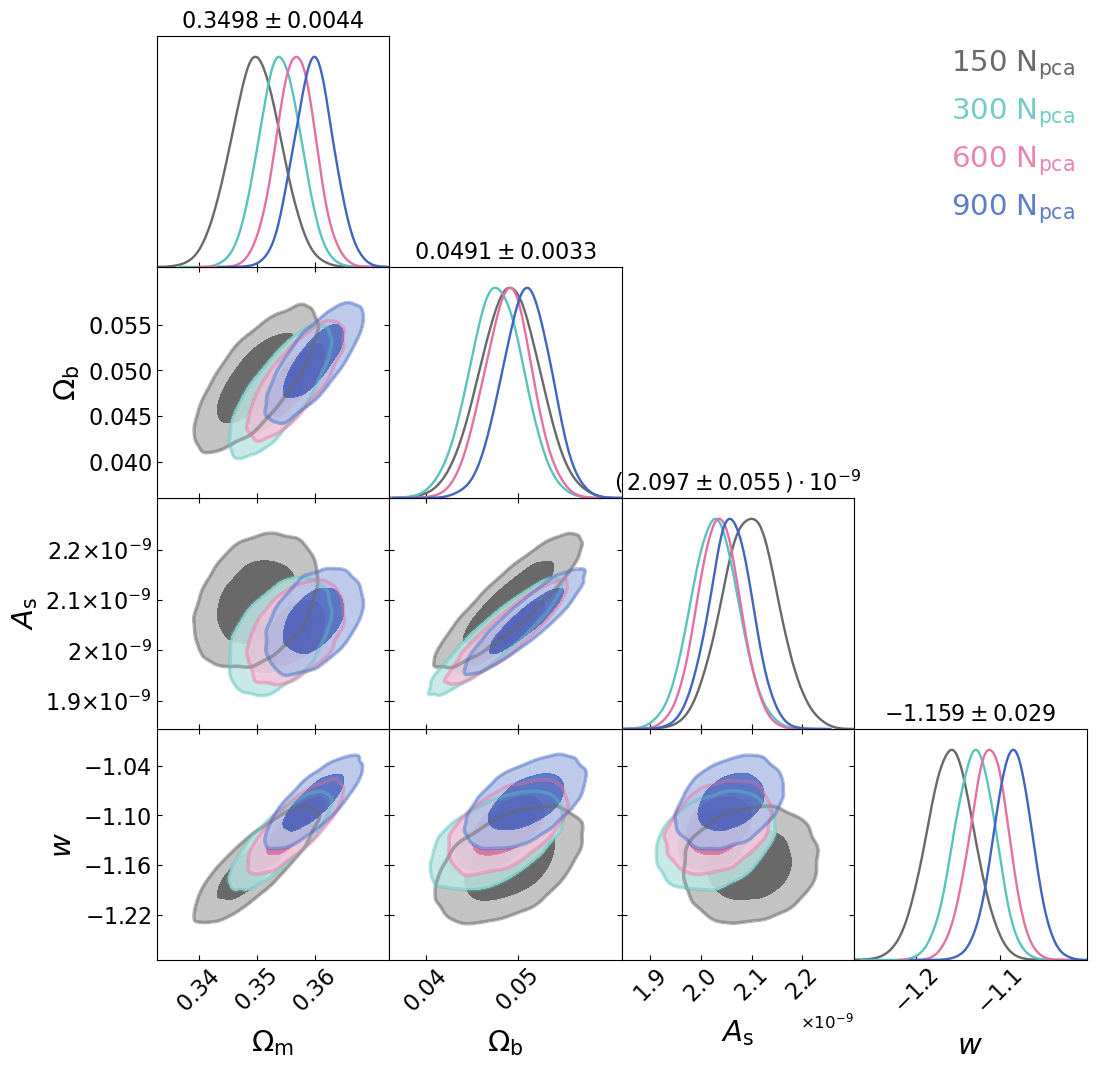

In [28]:
para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])

samples_array = [samples_pca_1_1500, samples_pca_2_1500, samples_pca_3_1500, samples_pca_4_1500]
samples_getdist_1500 = []
for sample in samples_array:
    samples_getdist_1500.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=samples_getdist_1500,
    filled=True,
    legend_loc='upper right',
    legend_labels = ['150 N$_\\text{pca}$', '300 N$_\\text{pca}$', '600 N$_\\text{pca}$', '900 N$_\\text{pca}$'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots/MCMC_A3_task4_1p5k_compare.jpg',dpi=400, bbox_inches='tight')

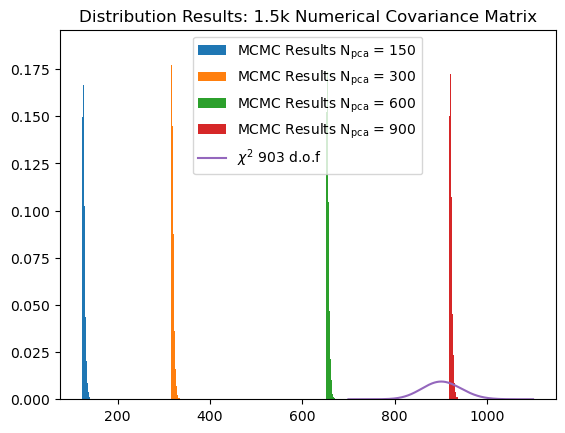

In [77]:
plt.hist(log_samples_1_1500*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 150')
plt.hist(log_samples_2_1500*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 300')
plt.hist(log_samples_3_1500*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 600')
plt.hist(log_samples_4_1500*(-2), bins=40, density=True, label=r'MCMC Results N$_\text{pca}$ = 900')
df = 903
x = np.linspace(700,1100,2000)
plt.plot(x, chi2.pdf(x, df), label=r'$\chi^2$ 903 d.o.f')
plt.title('Distribution Results: 1.5k Numerical Covariance Matrix')
plt.legend()
plt.show()

## Task 4.a

Text(0.5, 0.98, 'Marginalized Parameter Constraints as a Function of N$_\\text{pca}$')

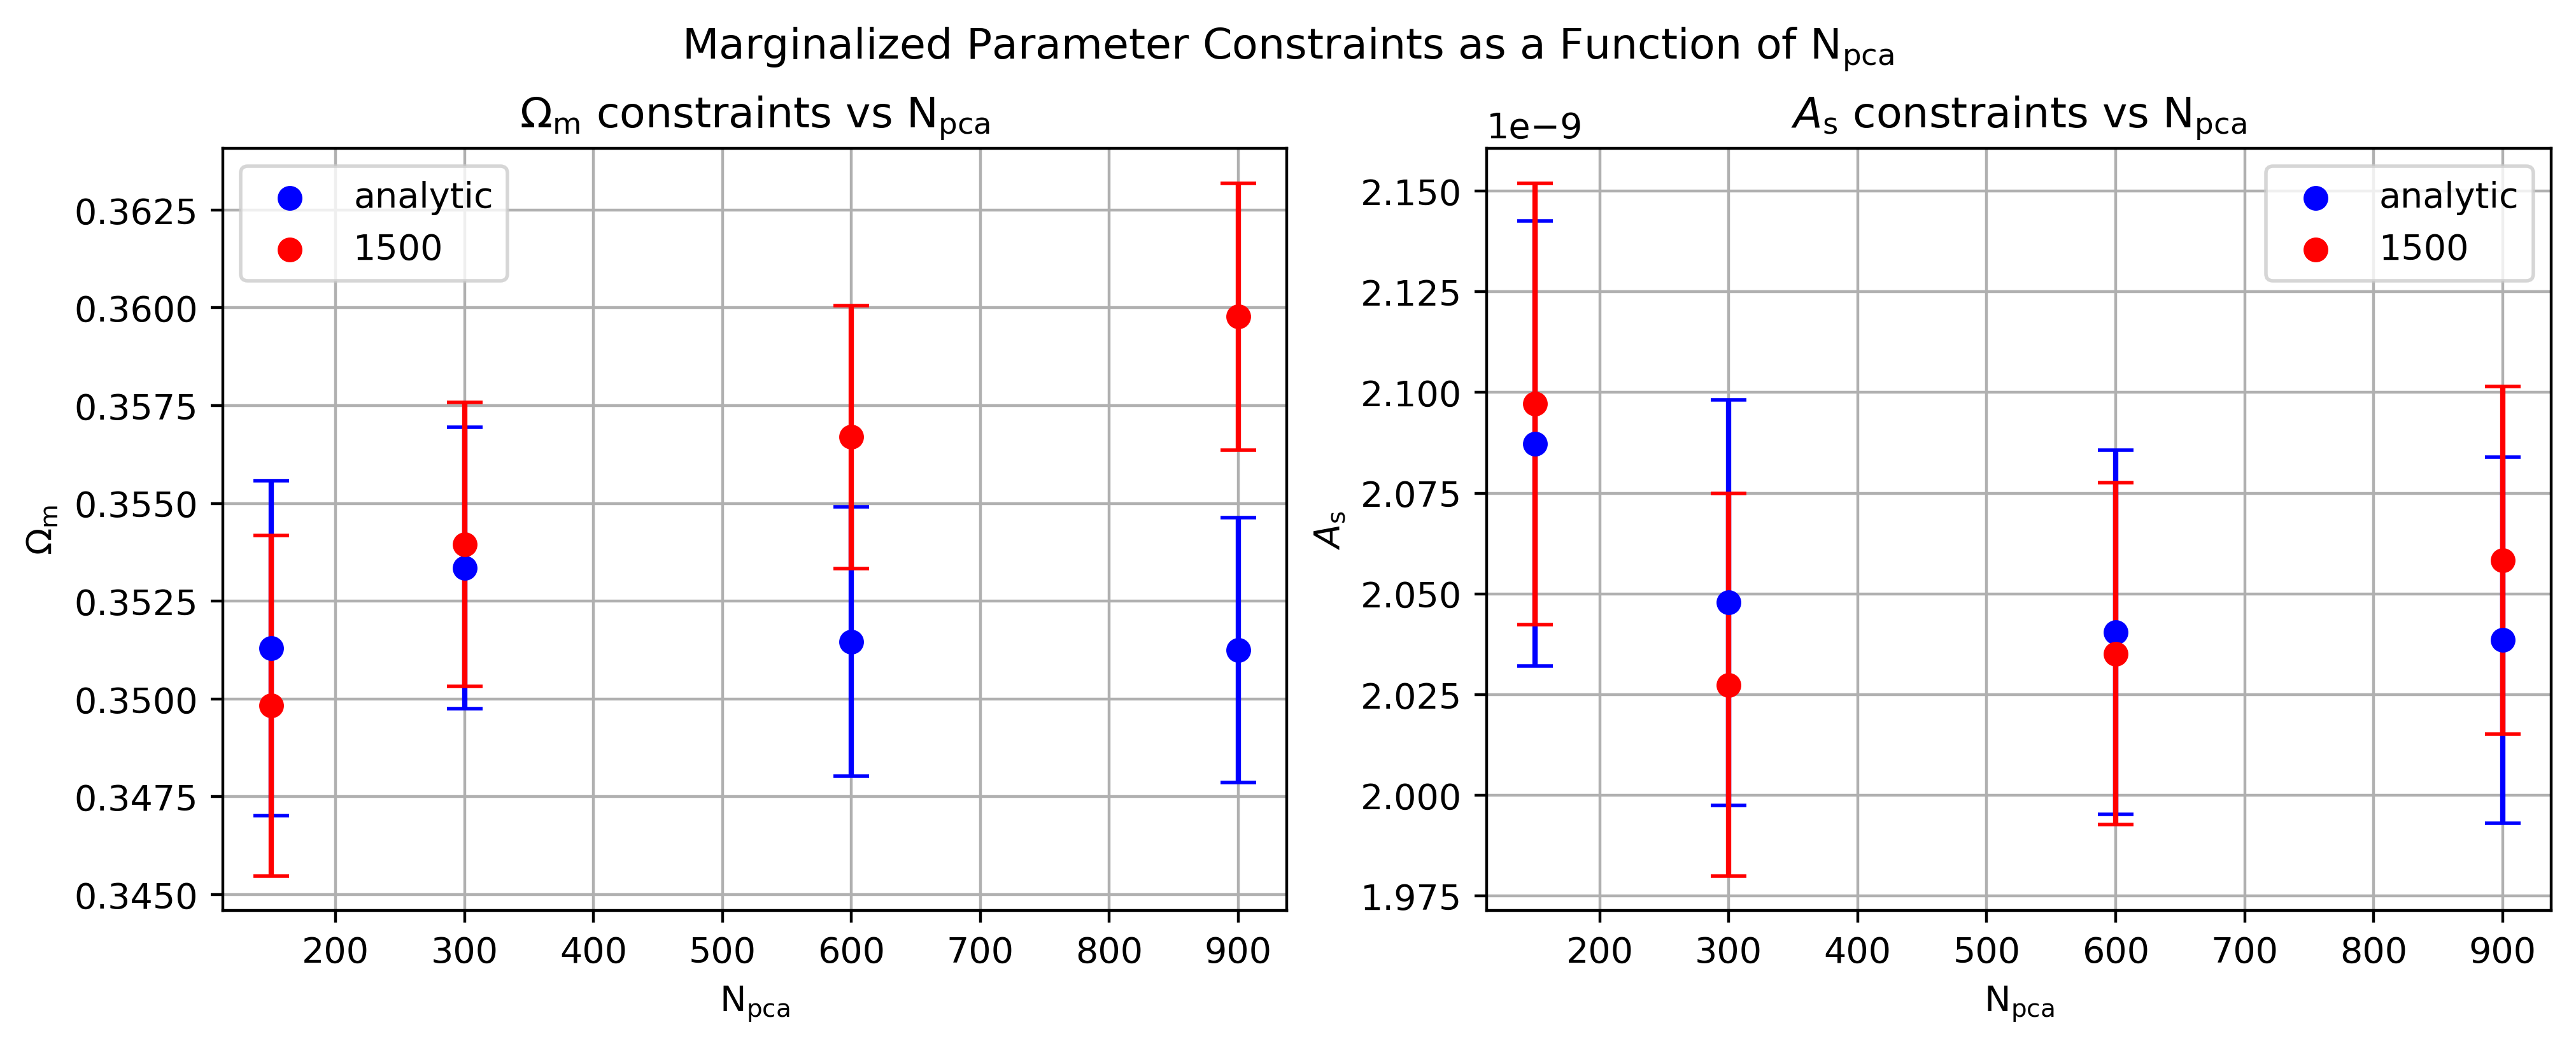

In [47]:
fig, ax = plt.subplots(1,2, figsize=(10,4), layout = "constrained", dpi=400)
for a, c in zip([0,1],[0,2]):
    for i in range(4):
        x = N_pca_array[i]
        y = samples_getdist_analytic[i].mean(c)
        y2 = samples_getdist_1500[i].mean(c)
        ax[a].errorbar(x, y, yerr = samples_getdist_analytic[i].std(c), capsize=5, c='b', zorder=3)
        ax[a].errorbar(x, y2, yerr = samples_getdist_1500[i].std(c), capsize=5, c='r', zorder=3)
        if i == 3:
            ax[a].scatter(x, y, c='b', zorder=3, label='analytic')
            ax[a].scatter(x, y2, c='r', zorder=3, label='1500')
        else:
            ax[a].scatter(x, y, c='b', zorder=3)
            ax[a].scatter(x, y2, c='r', zorder=3)
    ax[a].set(xlabel = 'N$_\\text{pca}$', ylabel = param_names_latex[c], \
                title=param_names_latex[c]+' constraints vs N$_\\text{pca}$')
    ax[a].legend()
    ax[a].grid()
fig.suptitle('Marginalized Parameter Constraints as a Function of N$_\\text{pca}$')

In [82]:
stds_4a = []
stds_4a_2 = []
for i in range(4):
    stds_4a.append(samples_getdist_analytic[i].std(c))
    stds_4a_2.append(samples_getdist_1500[i].std(c))

var_4a = np.var(stds_4a)
var_4a_2 = np.var(stds_4a_2)
var_4a, var_4a_2

(1.690796671567352e-23, 2.4273216787828406e-23)

## Task 4.b

In [50]:
models = np.load('data_4_assignment2/models.npy')
mean = np.mean(reference_model, axis=0)
num_runs = 8
N_pca = 150
for i in range(num_runs):
    pca = PCA(n_components=N_pca,svd_solver='full')
    models_pca = pca.fit(models-mean)
    rotation_matrix = pca.components_.T
    # Run using numerical 1500 covariance matrix
    n_r, n_d = 1500, N_pca
    h = (n_r-1)/(n_r-n_d-2)
    cov_pca = np.matmul(np.matmul(rotation_matrix.T,cov_num_1500),rotation_matrix)
    cov_inv = inv(cov_pca)/h
    
    iteration_seed = i*10
    p6 = start_position_lh_and_step_size_pca(iteration_seed)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood_pca)
    sampler.run_mcmc(p6, total_steps, progress=True)

    samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
    np.save('outputs_A3/MCMC_task4b_Npca{}_run{}_samples'.format(N_pca,i),samples_emcee)
    log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
    np.save('outputs_A3/logp_task4b_Npca{}_run{}_log'.format(N_pca,i),log_prob_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:10<00:00,  4.08it/s]


In [51]:
samples_4b_1 = np.load('outputs_A3/MCMC_task4b_Npca500_run0_samples.npy')
samples_4b_2 = np.load('outputs_A3/MCMC_task4b_Npca500_run1_samples.npy')
samples_4b_3 = np.load('outputs_A3/MCMC_task4b_Npca500_run2_samples.npy')
samples_4b_4 = np.load('outputs_A3/MCMC_task4b_Npca500_run3_samples.npy')
samples_4b_5 = np.load('outputs_A3/MCMC_task4b_Npca500_run4_samples.npy')
samples_4b_6 = np.load('outputs_A3/MCMC_task4b_Npca500_run5_samples.npy')
samples_4b_7 = np.load('outputs_A3/MCMC_task4b_Npca500_run6_samples.npy')
samples_4b_8 = np.load('outputs_A3/MCMC_task4b_Npca500_run7_samples.npy')

samples_4b_1_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run0_samples.npy')
samples_4b_2_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run1_samples.npy')
samples_4b_3_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run2_samples.npy')
samples_4b_4_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run3_samples.npy')
samples_4b_5_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run4_samples.npy')
samples_4b_6_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run5_samples.npy')
samples_4b_7_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run6_samples.npy')
samples_4b_8_2 = np.load('outputs_A3/MCMC_task4b_Npca150_run7_samples.npy')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


Text(0.5, 0.98, 'Comparison between multiple runs using 1500 covariance (with Hartlap factor)')

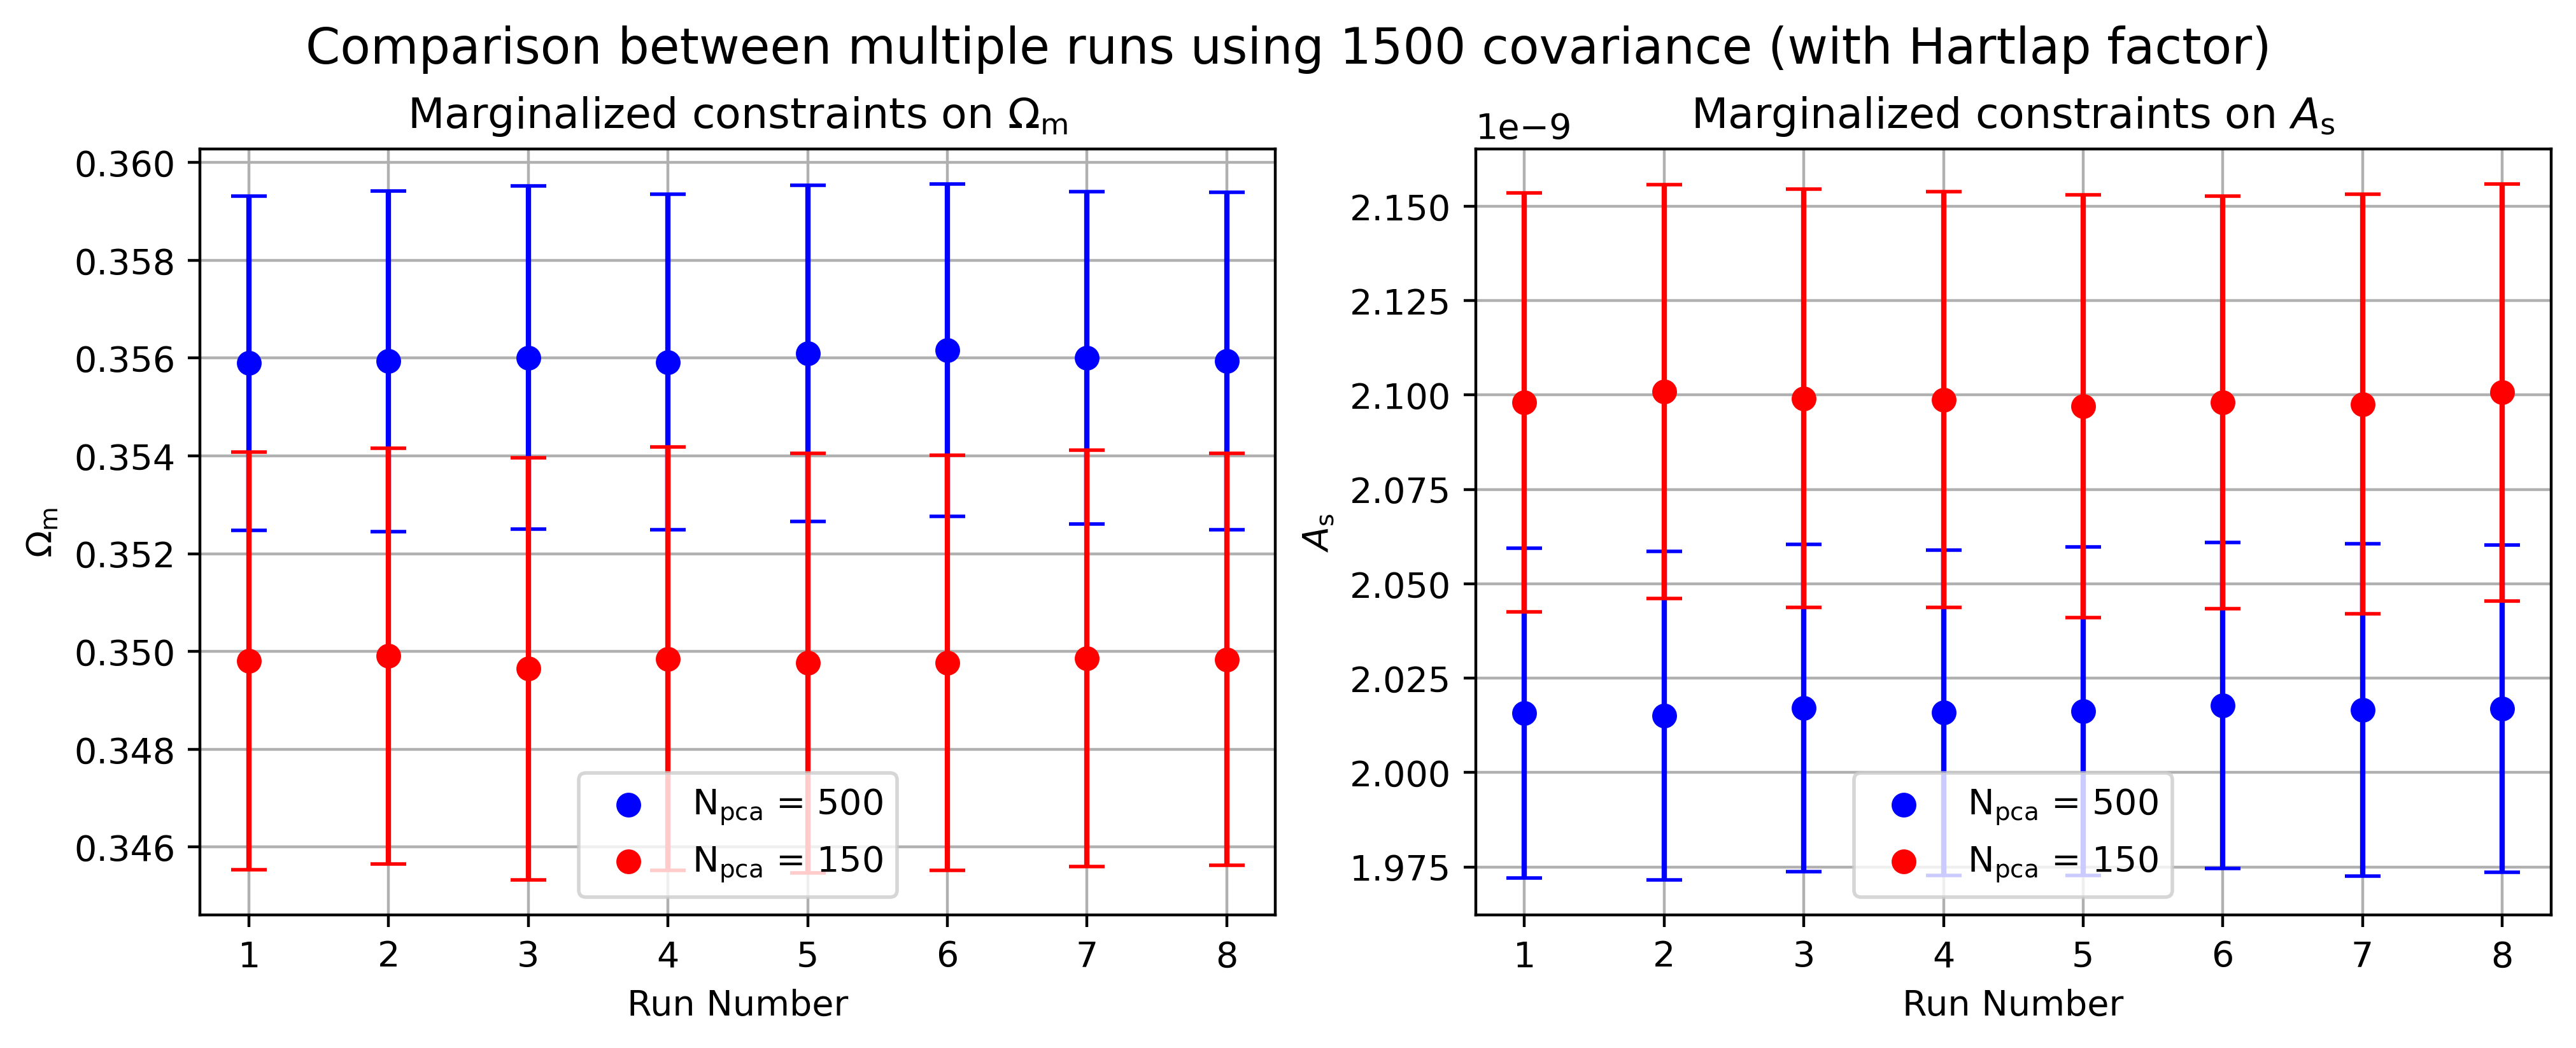

In [78]:
samples_array = [samples_4b_1, samples_4b_2, samples_4b_3, samples_4b_4, samples_4b_5, samples_4b_6, samples_4b_7, samples_4b_8]
samples_array_2 = [samples_4b_1_2, samples_4b_2_2, samples_4b_3_2, samples_4b_4_2, samples_4b_5_2, samples_4b_6_2, samples_4b_7_2, samples_4b_8_2]
samples_getdist_4b = []
samples_getdist_4b_2 = []
for sample in samples_array:
    samples_getdist_4b.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))

for sample in samples_array_2:
    samples_getdist_4b_2.append(MCSamples(samples=sample, names = param_names_latex, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}))
    
x = np.array([1,2,3,4,5,6,7,8])
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=400, layout='constrained')
for a, b in zip([0,1], [0,2]):
    for i in range(num_runs):
        label, label2 = None, None
        if i == num_runs-1:
            label = r'N$_\text{pca}$ = 500'
            label2 = r'N$_\text{pca}$ = 150'
        y = samples_getdist_4b[i].mean(b)
        y2 = samples_getdist_4b_2[i].mean(b)
        yerr = samples_getdist_4b[i].std(b)
        yerr2 = samples_getdist_4b_2[i].std(b)
        ax[a].errorbar(x[i], y, yerr=yerr, capsize = 5, c='b', zorder=3)
        ax[a].scatter(x[i], y, c='b', zorder=3, label=label)
        ax[a].errorbar(x[i], y2, yerr=yerr2, capsize = 5, c='r', zorder=3)
        ax[a].scatter(x[i], y2, c='r', zorder=3, label=label2)
    ax[a].grid()
    ax[a].legend()
    ax[a].set(xlabel='Run Number', ylabel=param_names_latex[b], title='Marginalized constraints on '+param_names_latex[b])
fig.suptitle('Comparison between multiple runs using 1500 covariance (with Hartlap factor)',fontsize=14)

In [83]:
stds_4b = []
stds_4b_2 = []
for i in range(8):
    stds_4b.append(samples_getdist_4b[i].std(c))
    stds_4b_2.append(samples_getdist_4b_2[i].std(c))

var_4b = np.var(stds_4b)
var_4b_2 = np.var(stds_4b_2)
var_4b, var_4b_2

(8.150224589586478e-26, 1.6536602864609129e-25)

# Task 4 Discussion
We observe the same trends using the noise free reference model in this task, compared to the noisy reference model in part 3. This is counterintuitive, as the noise free reference model should provide $\chi^2$ distributions centered at 4 because the degrees of freedom now only come from the variation in the parameters, not the variation in the data. Additionally, it is also strange that the analytical and 1500 numerical covariance matrices provide equivalent (or almost equivalent) results. This is counterintuitive as well, as the analytical covariance matrix should be providing much more accurate results.

## Part a)
We observe that the marginalized constraints on $\Omega_\text{b}$ and $A_\text{s}$ for both the analytical and 1500 covariance matrices vary slightly in the mean. However, although small, the standard deviations do decrease as N$_\text{pca}$ increases.

## Part b)
We have run two sets of 8 different seed runs for 150 and 500 PCA elements. We see that the variation on the mean is small. Additionally, we see that the variance of the standard deviations in this task are multiple orders of magnitude smaller than the variance measured in $4.a$. This means we can trust that our results in $4.a$ are reliable. To improve $4.a$, we can apply what we have done in this task (repeated runs with the same PCA elements) for each number of PCA elements in $4.a$, and take the averages of the means and standard deviations.